In [1]:
#Import Library
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU
from tensorflow.keras import regularizers

In [2]:
#global variable
NUM_WORDS = 1000
OOV_TOKEN = "<OOV>"
PADDING = 'post'
MAXLEN = 120
EMBEDDING_DIM = 16

In [3]:
#Retrieve DS from Github
dataset_link = 'https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv'
response = requests.get(dataset_link)

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv')
# Identify Unnamed columns
unnamed_columns = [col for col in data.columns if 'Unnamed' in col]

# Drop Unnamed columns
data = data.drop(unnamed_columns, axis=1)
#shuffle data
data = data.sample(frac=1)

print(data.head())
print("\n")
print(data.tail())

       Label                                              Tweet
1371  Non_HS                    Pengen anjing kayak gini sayang
1552  Non_HS  Anjing penolong membantu orang dengan kebutuha...
1815      HS  Keputusan ERKA hari ini harus kita HORMATI, be...
2041      HS  rezim diktator amp otoriter ulama mahasiswa to...
2354      HS                         Mana ada anjir. Kagak lah.


       Label                                              Tweet
2670      HS                            ga bakal pak mereka bbc
822   Non_HS  hahahahahahaahahaha aku jauh kot siapa nk amik...
2054      HS  gubernur daerah khusus ibukota pe arung sumber...
3320      HS                                           Anak asu
1578  Non_HS  Anjing itu menggonggong saat ada tamu di depan...


In [5]:
data['Label'].value_counts()

HS        1722
Non_HS    1688
Name: Label, dtype: int64

In [6]:
def parse_data(data):
    labels = []
    tweets = []

    for _, row in data.iterrows():
        cond = (0 if row['Label'] == "HS" else 1)
        labels.append(cond)
        tweets.append(row['Tweet'])

    return labels, tweets

# Assuming 'data' is your DataFrame
labels, tweets = parse_data(data)

In [7]:
print(f"Example number in dataset is {len(tweets)} examples\n")

print(f"2nd example:\n{tweets[1]}\n")
print(f"Last example:\n{tweets[-1]}")

Example number in dataset is 3410 examples

2nd example:
Anjing penolong membantu orang dengan kebutuhan khusus sehari-hari.

Last example:
Anjing itu menggonggong saat ada tamu di depan pintu.


In [8]:
#90-10 ratio train-test
def train_test_split(labels,tweets):
    train_size = int(len(tweets) * 0.9)

    train_labels = labels[:train_size]
    train_tweets = tweets[:train_size]

    test_labels = labels[train_size:]
    test_tweets = tweets[train_size:]

    return train_labels, train_tweets, test_labels, test_tweets

In [9]:
train_labels, train_tweets, test_labels, test_tweets = train_test_split(labels, tweets)

print(f" {len(train_labels)} sentences for training.")
print(f" {len(train_tweets)} labels for training.")
print(f" {len(test_labels)} sentences for validation.")
print(f" {len(test_tweets)} labels for validation.")

 3069 sentences for training.
 3069 labels for training.
 341 sentences for validation.
 341 labels for validation.


In [10]:
print(train_tweets[:3])
print(train_labels[:3])
print(test_tweets[:3])
print(test_labels[:3])

['Pengen anjing kayak gini sayang', 'Anjing penolong membantu orang dengan kebutuhan khusus sehari-hari.', 'Keputusan ERKA hari ini harus kita HORMATI, begitupun sebaliknya KAMI tidak akan memilih partai pendukung PENISTA AGAMA.']
[1, 1, 0]
['Anjing itu menggonggong marah pada kucing yang mengganggunya.', 'Mengapa mereka melakukan ini, apakah bisa merubah keadaan bagi para pemilih nanti ? ', 'Pencitraan di socmed itu boleh-boleh aja. Tapi harus bisa tanggung jawab sama citra yang udh dibikin. Jangan sampe jadi malu-maluin. Kasian.']
[1, 1, 1]


In [11]:
#tokenizer function
def fit_tokenizer(train_sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [12]:
#buat test doang
def lowercase(list_sentence):
    lower_sentence = list_sentence
    for i in range(len(list_sentence)):
        lower_sentence[i] = lower_sentence[i].lower()
    return lower_sentence

In [13]:
#tokenize sentence
#test_tweets1 = test_tweets[0].lower()
#test_tweets1 = test_tweets1.lower()
lower_train_tweets = lowercase(train_tweets)
tokenizer = fit_tokenizer(lower_train_tweets, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 8463 words

<OOV> token included in vocabulary


In [14]:
#seq and padding function
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding)
    return padded_sequences

In [15]:
#seq and padding sentence
lower_val_tweets = lowercase(test_tweets)
train_padded_seq = seq_and_pad(lower_train_tweets, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(lower_val_tweets, tokenizer, PADDING, MAXLEN)
print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (3069, 120)

Padded validation sequences have shape: (341, 120)


In [16]:
#Model Structure
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length = MAXLEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units = 32, activation= 'relu'),
    tf.keras.layers.Dense(units = 2, activation='softmax')
])

In [17]:
print(type(test_labels))

<class 'list'>


In [18]:
test_labels_changed = np.array(test_labels)
print(type(test_labels_changed))
print(type(train_padded_seq))
print(type(val_padded_seq))
print(type(train_labels))
print("\n")
print(train_padded_seq)
print("\n")
print(val_padded_seq)
print(test_labels_changed[:10])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


[[194   4 168 ...   0   0   0]
 [  4   1 174 ...   0   0   0]
 [  1   1  88 ...   0   0   0]
 ...
 [232   1   4 ...   0   0   0]
 [ 43  63 755 ...   0   0   0]
 [ 99  21   1 ...   0   0   0]]


[[  4   8 318 ...   0   0   0]
 [618  36 507 ...   0   0   0]
 [440   6   1 ...   0   0   0]
 ...
 [124   1 604 ...   0   0   0]
 [ 55 257   0 ...   0   0   0]
 [  4   8 318 ...   0   0   0]]
[1 1 1 0 1 0 0 0 0 1]


In [19]:
train_labels_changed = np.array(train_labels)
print(train_labels_changed)

[1 1 0 ... 0 0 1]


In [20]:
# Menggunakan LabelEncoder untuk mengubah label menjadi bilangan bulat
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_changed)
test_labels_encoded = label_encoder.transform(test_labels_changed)

# Mengubah label menjadi one-hot encoded
num_classes = len(label_encoder.classes_)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=num_classes)

In [21]:
print(train_labels_encoded)
print("\n")
print(test_labels_encoded)
print("\n")
print(train_labels_one_hot)
print("\n")
print(test_labels_one_hot)

[1 1 0 ... 0 0 1]


[1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1
 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1
 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1
 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0
 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0
 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1
 1 0 0 0 1 0 0 1]


[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.

In [22]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

history_1 = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 2s 8ms/step - loss: 0.6929 - accuracy: 0.5109 - val_loss: 0.6934 - val_accuracy: 0.4751
Epoch 2/30
96/96 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5217 - val_loss: 0.6913 - val_accuracy: 0.4751
Epoch 3/30
96/96 [==============================] - 1s 5ms/step - loss: 0.6807 - accuracy: 0.6435 - val_loss: 0.6719 - val_accuracy: 0.8094
Epoch 4/30
96/96 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.7312 - val_loss: 0.6296 - val_accuracy: 0.7742
Epoch 5/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5743 - accuracy: 0.8283 - val_loss: 0.5554 - val_accuracy: 0.8182
Epoch 6/30
96/96 [==============================] - 0s 3ms/step - loss: 0.4818 - accuracy: 0.8491 - val_loss: 0.4893 - val_accuracy: 0.8240
Epoch 7/30
96/96 [==============================] - 0s 3ms/step - loss: 0.4087 - accuracy: 0.8638 - val_loss: 0.4484 - val_accuracy: 0.8299
Epoch 8/30
96/96 [==

In [23]:
seed_text = "anjing liar"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.42827135 0.57172865]]


In [24]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(amsgrad = True) ,metrics=['accuracy'])

history_2 = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 1s 5ms/step - loss: 0.1544 - accuracy: 0.9449 - val_loss: 0.4398 - val_accuracy: 0.8358
Epoch 2/30
96/96 [==============================] - 0s 4ms/step - loss: 0.1500 - accuracy: 0.9466 - val_loss: 0.4411 - val_accuracy: 0.8328
Epoch 3/30
96/96 [==============================] - 0s 3ms/step - loss: 0.1472 - accuracy: 0.9459 - val_loss: 0.4461 - val_accuracy: 0.8328
Epoch 4/30
96/96 [==============================] - 0s 3ms/step - loss: 0.1433 - accuracy: 0.9508 - val_loss: 0.4544 - val_accuracy: 0.8416
Epoch 5/30
96/96 [==============================] - 0s 3ms/step - loss: 0.1399 - accuracy: 0.9521 - val_loss: 0.4722 - val_accuracy: 0.8299
Epoch 6/30
96/96 [==============================] - 0s 3ms/step - loss: 0.1359 - accuracy: 0.9524 - val_loss: 0.4630 - val_accuracy: 0.8299
Epoch 7/30
96/96 [==============================] - 1s 15ms/step - loss: 0.1331 - accuracy: 0.9554 - val_loss: 0.4697 - val_accuracy: 0.8328
Epoch 8/30
96/96 [=

In [25]:
seed_text = "anjing liar"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.27386314 0.7261369 ]]


In [26]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.SGD(nesterov=True) ,metrics=['accuracy'])

history_3 = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 1s 5ms/step - loss: 3.2342 - accuracy: 0.6357 - val_loss: 0.5486 - val_accuracy: 0.8416
Epoch 2/30
96/96 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.7201 - val_loss: 0.5559 - val_accuracy: 0.7918
Epoch 3/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5083 - accuracy: 0.6905 - val_loss: 0.6334 - val_accuracy: 0.4985
Epoch 4/30
96/96 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.7087 - val_loss: 0.5866 - val_accuracy: 0.4751
Epoch 5/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5275 - accuracy: 0.6706 - val_loss: 0.6315 - val_accuracy: 0.7419
Epoch 6/30
96/96 [==============================] - 0s 5ms/step - loss: 0.5449 - accuracy: 0.6797 - val_loss: 0.6208 - val_accuracy: 0.7595
Epoch 7/30
96/96 [==============================] - 0s 5ms/step - loss: 0.5446 - accuracy: 0.5917 - val_loss: 0.6666 - val_accuracy: 0.4809
Epoch 8/30
96/96 [==

In [27]:
seed_text = "anjing liar"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.29822484 0.7017752 ]]


In [28]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.SGD() ,metrics=['accuracy'])

history_4 = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 1s 5ms/step - loss: 0.6263 - accuracy: 0.5562 - val_loss: 0.6671 - val_accuracy: 0.5777
Epoch 2/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5807 - accuracy: 0.6869 - val_loss: 0.6537 - val_accuracy: 0.6276
Epoch 3/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5766 - accuracy: 0.6276 - val_loss: 0.5850 - val_accuracy: 0.5308
Epoch 4/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5716 - accuracy: 0.6455 - val_loss: 0.6424 - val_accuracy: 0.6686
Epoch 5/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5379 - accuracy: 0.6243 - val_loss: 0.6253 - val_accuracy: 0.5249
Epoch 6/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5642 - accuracy: 0.5852 - val_loss: 0.6600 - val_accuracy: 0.7097
Epoch 7/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5523 - accuracy: 0.6667 - val_loss: 0.6676 - val_accuracy: 0.5718
Epoch 8/30
96/96 [==

In [29]:
seed_text = "anjing liar"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.7047452 0.2952548]]


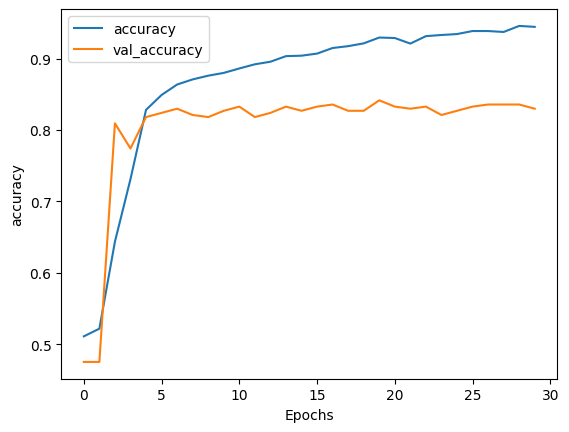

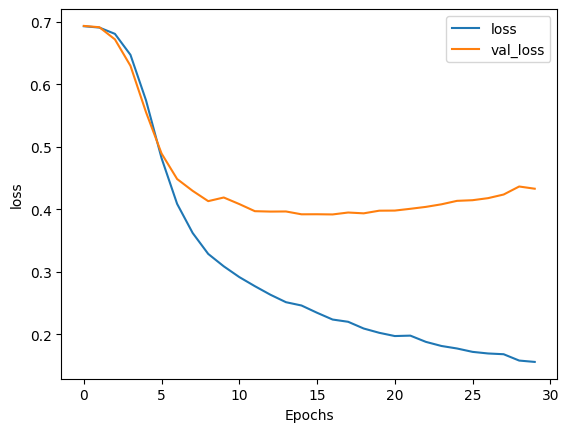

In [30]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

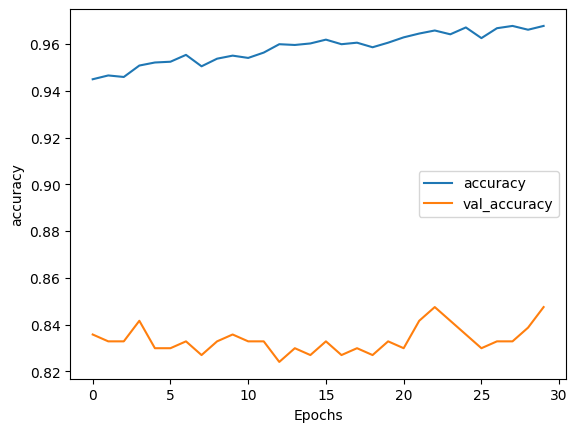

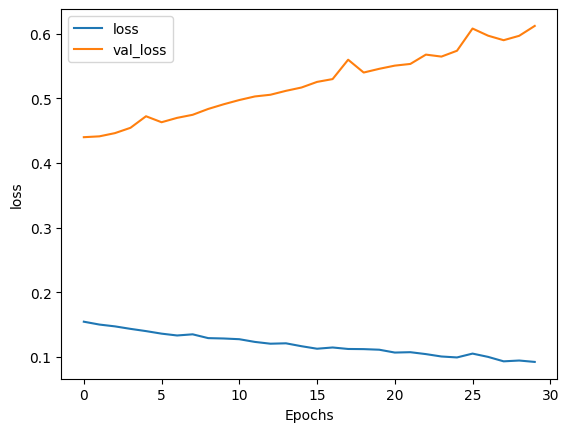

In [31]:
plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

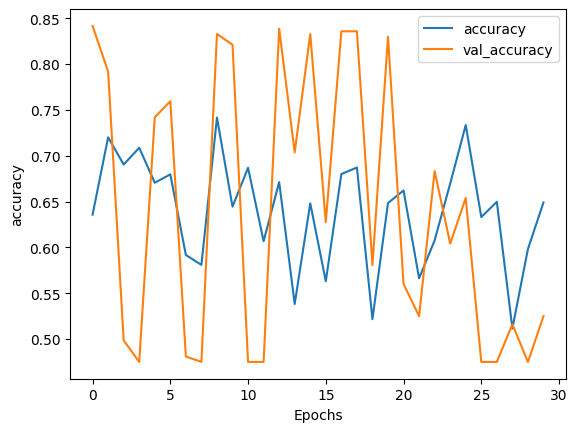

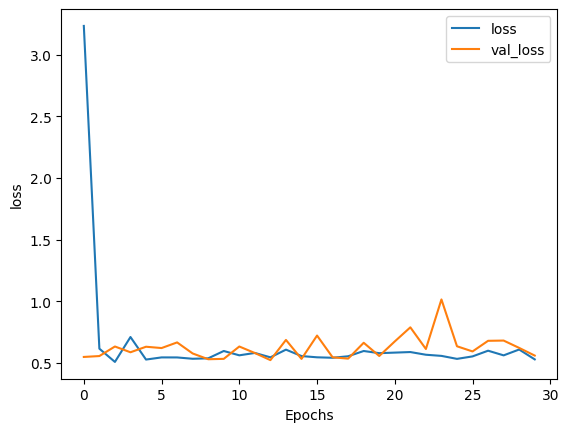

In [32]:
plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

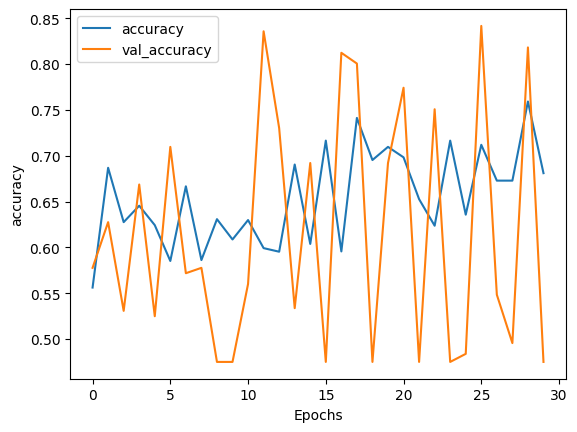

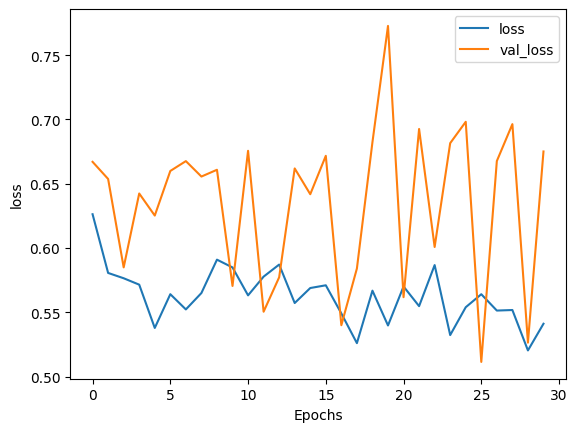

In [33]:
plot_graphs(history_4, "accuracy")
plot_graphs(history_4, "loss")

In [34]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 30s 226ms/step - loss: 0.6929 - accuracy: 0.5103 - val_loss: 0.6902 - val_accuracy: 0.7097
Epoch 2/30
96/96 [==============================] - 19s 198ms/step - loss: 0.5133 - accuracy: 0.7810 - val_loss: 0.4741 - val_accuracy: 0.8270
Epoch 3/30
96/96 [==============================] - 20s 206ms/step - loss: 0.3599 - accuracy: 0.8609 - val_loss: 0.4661 - val_accuracy: 0.7801
Epoch 4/30
96/96 [==============================] - 19s 198ms/step - loss: 0.2934 - accuracy: 0.8869 - val_loss: 0.4127 - val_accuracy: 0.8270
Epoch 5/30
96/96 [==============================] - 20s 207ms/step - loss: 0.2444 - accuracy: 0.9140 - val_loss: 0.4040 - val_accuracy: 0.8211
Epoch 6/30
96/96 [==============================] - 19s 198ms/step - loss: 0.2136 - accuracy: 0.9277 - val_loss: 0.4288 - val_accuracy: 0.8240
Epoch 7/30
96/96 [==============================] - 21s 223ms/step - loss: 0.2218 - accuracy: 0.9326 - val_loss: 0.4283 - val_accuracy: 0.8328

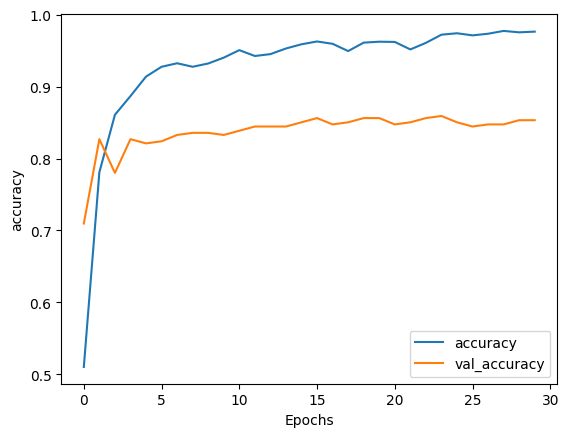

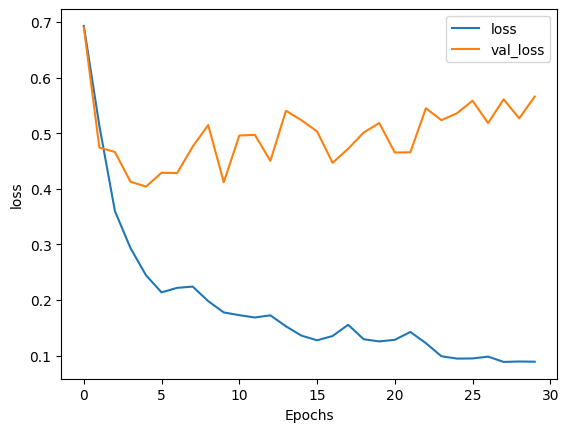

In [35]:
plot_graphs(history_LSTM, "accuracy")
plot_graphs(history_LSTM, "loss")

In [36]:
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
history_LSTM_2 = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 30s 223ms/step - loss: 0.8585 - accuracy: 0.5178 - val_loss: 0.6970 - val_accuracy: 0.4751
Epoch 2/30
96/96 [==============================] - 20s 208ms/step - loss: 0.6950 - accuracy: 0.4813 - val_loss: 0.6960 - val_accuracy: 0.4751
Epoch 3/30
96/96 [==============================] - 19s 195ms/step - loss: 0.6924 - accuracy: 0.5083 - val_loss: 0.6936 - val_accuracy: 0.4751
Epoch 4/30
96/96 [==============================] - 20s 210ms/step - loss: 0.6907 - accuracy: 0.5083 - val_loss: 0.6927 - val_accuracy: 0.4751
Epoch 5/30
96/96 [==============================] - 18s 192ms/step - loss: 0.6886 - accuracy: 0.5191 - val_loss: 0.6915 - val_accuracy: 0.4751
Epoch 6/30
96/96 [==============================] - 20s 209ms/step - loss: 0.6861 - accuracy: 0.5174 - val_loss: 0.6888 - val_accuracy: 0.4751
Epoch 7/30
96/96 [==============================] - 19s 193ms/step - loss: 0.6813 - accuracy: 0.5490 - val_loss: 0.6834 - val_accuracy: 0.5044

In [37]:
# Definisikan callback function
class LearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Dapatkan learning rate berdasarkan epoch saat ini
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        # Panggil fungsi schedule untuk mendapatkan learning rate baru
        scheduled_lr = self.schedule(epoch, lr)
        # Atur learning rate pada optimizer
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f"\nEpoch {epoch + 1}: Learning rate set to {scheduled_lr}")

# Fungsi untuk mengatur schedule learning rate
def learning_rate_schedule(epoch, lr):
    # Learning rate akan berkurang setiap 5 epoch
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.1  # Mengurangi learning rate menjadi 10% dari sebelumnya
    return lr

In [38]:
# Compile model
# Adam Opt
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics=['accuracy'])

# Membuat instance dari LearningRateScheduler
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Latih model dengan menggunakan callback LearningRateScheduler
history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30,
                              validation_data=(val_padded_seq, test_labels_one_hot),
                              callbacks=[lr_scheduler])


Epoch 1: Learning rate set to 0.0010000000474974513
Epoch 1/30
96/96 [==============================] - 30s 224ms/step - loss: 0.0989 - accuracy: 0.9723 - val_loss: 0.5598 - val_accuracy: 0.8563

Epoch 2: Learning rate set to 0.0010000000474974513
Epoch 2/30
96/96 [==============================] - 19s 193ms/step - loss: 0.0903 - accuracy: 0.9746 - val_loss: 0.5517 - val_accuracy: 0.8475

Epoch 3: Learning rate set to 0.0010000000474974513
Epoch 3/30
96/96 [==============================] - 21s 222ms/step - loss: 0.0857 - accuracy: 0.9785 - val_loss: 0.5696 - val_accuracy: 0.8475

Epoch 4: Learning rate set to 0.0010000000474974513
Epoch 4/30
96/96 [==============================] - 18s 193ms/step - loss: 0.0878 - accuracy: 0.9765 - val_loss: 0.5779 - val_accuracy: 0.8504

Epoch 5: Learning rate set to 0.0010000000474974513
Epoch 5/30
96/96 [==============================] - 20s 210ms/step - loss: 0.0916 - accuracy: 0.9739 - val_loss: 0.5871 - val_accuracy: 0.8446

Epoch 6: Learning r

In [39]:
# SGD Opt
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(momentum = 0.9), metrics=['accuracy'])
history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30,
                              validation_data=(val_padded_seq, test_labels_one_hot),
                              callbacks=[lr_scheduler])


Epoch 1: Learning rate set to 0.009999999776482582
Epoch 1/30
96/96 [==============================] - 28s 220ms/step - loss: 0.3334 - accuracy: 0.8830 - val_loss: 0.5117 - val_accuracy: 0.7859

Epoch 2: Learning rate set to 0.009999999776482582
Epoch 2/30
96/96 [==============================] - 18s 191ms/step - loss: 0.3353 - accuracy: 0.8671 - val_loss: 0.4917 - val_accuracy: 0.8094

Epoch 3: Learning rate set to 0.009999999776482582
Epoch 3/30
96/96 [==============================] - 20s 205ms/step - loss: 0.3311 - accuracy: 0.8625 - val_loss: 0.5216 - val_accuracy: 0.8182

Epoch 4: Learning rate set to 0.009999999776482582
Epoch 4/30
96/96 [==============================] - 18s 191ms/step - loss: 0.2663 - accuracy: 0.8941 - val_loss: 0.4722 - val_accuracy: 0.8299

Epoch 5: Learning rate set to 0.009999999776482582
Epoch 5/30
96/96 [==============================] - 20s 206ms/step - loss: 0.2237 - accuracy: 0.9127 - val_loss: 0.7666 - val_accuracy: 0.4751

Epoch 6: Learning rate s

In [40]:
model.save('model.h5')

In [41]:
# Load model Keras dari file .h5
model = tf.keras.models.load_model('model.h5')

# Inisialisasi TFLiteConverter dengan model Keras
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Konversi model menjadi format TFLite
tflite_model = converter.convert()

In [42]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)